# Training Deep Neural Nets
---


In [2]:
# Content 



## Vanishing/Exploding Gradients Problems

The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get *smaller and smaller* as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called the `vanishing gradients problem.`

In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely 
large weight updates and the algorithm diverges. This is the exploding gradients problem, 
which is mostly encountered in recurrent neural networks

Looking at the logistic activation function , you can see that when
inputs become large (negative or positive), the function saturates at 0 or 1, with a
derivative extremely close to 0. Thus when backpropagation kicks in, it has virtually
no gradient to propagate back through the network, and what little gradient exists
keeps getting diluted as backpropagation progresses down through the top layers, so
there is really nothing left for the lower layers.


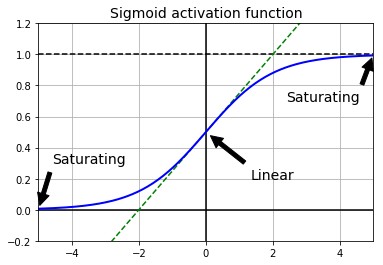

In [12]:
import numpy as np 

def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

To resolve this problem the authors argue that we need the variance of the
outputs of each layer to be equal to the variance of its inputs, and we also need the
gradients to have equal variance before and after flowing through a layer in the
reverse direction

It is actually not possible to guarantee both unless the layer has an equal
number of input and output connections, but they proposed a good compromise that
has proven to work very well in practice: the connection weights must be initialized
randomly

This initialization strategy is often called Xavier initialization
(after the author’s first name), or sometimes Glorot initialization.

Using the Xavier initialization strategy can speed up training considerably, and it is
one of the tricks that led to the current success of Deep Learning.

By default, the fully_connected() function (introduced in Chapter 10) uses Xavier
initialization (with a uniform distribution). You can change this to He initialization
by using the variance_scaling_initializer() function like this:



In [13]:
import tensorflow as tf

tf.reset_default_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

# Nonsaturating Activation Functions

ReLU is better than logistic function, unfortunately, the ReLU activation function is not perfect. It suffers from a problem
known as the dying ReLUs: during training, some neurons effectively die, meaning
they stop outputting anything other than 0. In some cases, you may find that half of
your network’s neurons are dead, especially if you used a large learning rate. During
training, if a neuron’s weights get updated such that the weighted sum of the neuron’s
inputs is negative, it will start outputting 0. When this happen, the neuron is unlikely
to come back to life since the gradient of the ReLU function is 0 when its input is
negative.

To solve this problem, you may want to use a variant of the ReLU function, such as
the leaky ReLU. This function is defined as LeakyReLUα(z) = max(αz, z)

The hyperparameter α defines how much the function “leaks”: it is the
slope of the function for z < 0, and is typically set to 0.01. This small slope ensures
that leaky ReLUs never die; they can go into a long coma, but they have a chance to
eventually wake up.

### leaky ReLUs

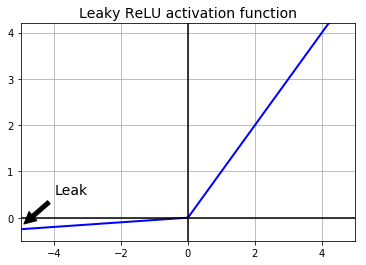

In [15]:
import matplotlib.pyplot as plt

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

**Implementing Leakly Relu in TF**

In [17]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

# Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

tf.reset_default_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9046
5 Batch accuracy: 0.92 Validation accuracy: 0.9496
10 Batch accuracy: 0.94 Validation accuracy: 0.9644
15 Batch accuracy: 0.98 Validation accuracy: 0.9708
20 Batch accuracy: 0.98 Validation accuracy: 0.974
25 Batch accuracy: 1.0 Validation accuracy: 0.9756
30 Batch accuracy: 1.0 Validation accuracy: 0.9772
35 Batch accuracy: 1.0 Validation accuracy: 0.9798


### ELU activation function

In [31]:
# Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

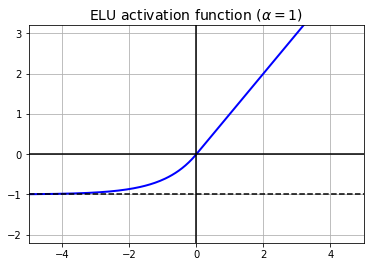

In [32]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

The main drawback of the ELU activation function is that it is slower to compute
than the ReLU and its variants (due to the use of the exponential function), but during
training this is compensated by the faster convergence rate. However, at test time
an ELU network will be slower than a ReLU network.

**Note** Which choose?!:
    
So which activation function should you use for the hidden layers
of your deep neural networks? Although your mileage will vary, in
general ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic.
If you care a lot about runtime performance, then you may prefer
leaky ReLUs over ELUs. If you don’t want to tweak yet another
hyperparameter, you may just use the default α values suggested
earlier (0.01 for the leaky ReLU, and 1 for ELU). If you have spare
time and computing power, you can use cross-validation to evaluate
other activation functions, in particular RReLU if your network
is overfitting, or PReLU if you have a huge training set.

## Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly
reduce the vanishing/exploding gradients problems at the beginning of training,
it doesn’t guarantee that they won’t come back during training.

The technique consists of adding an operation in the model just before the activation
function of each layer, simply zero-centering and normalizing the inputs, then scaling
and shifting the result using two new parameters per layer (one for scaling, the other
for shifting). **In other words, this operation lets the model learn the optimal scale and
mean of the inputs for each layer.**

In order to zero-center and normalize the inputs, the algorithm needs to estimate the
inputs’ mean and standard deviation. It does so by evaluating the mean and standard
deviation of the inputs over the current mini-batch (hence the name “Batch Normalization

The authors demonstrated that this technique considerably improved all the deep
neural networks they experimented with. The vanishing gradients problem was
strongly reduced, to the point that they could use saturating activation functions such
as the tanh and even the logistic activation function. The networks were also much
less sensitive to the weight initialization. They were able to use much larger learning
rates, significantly speeding up the learning process

Batch Normalization also acts like a regularizer, reducing the need for other regularization techniques (Dropout)

Batch Normalization does, however, add some complexity to the model (although it 
removes the need for normalizing the input data since the first hidden layer will take
care of that, provided it is batch-normalized). Moreover, there is a runtime penalty:
the neural network makes slower predictions due to the extra computations required
at each layer. So if you need predictions to be lightning-fast, you may want to check
how well plain ELU + He initialization perform before playing with Batch Normalization.

In [33]:
tf.reset_default_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')


In [34]:
# To avoid repeating the same parameters over and over again, we can use Python's partial() function:

from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [35]:
## Practical example with MNIST and Normalization

tf.reset_default_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.894
1 Validation accuracy: 0.9138
2 Validation accuracy: 0.9286
3 Validation accuracy: 0.94
4 Validation accuracy: 0.9472
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9544
7 Validation accuracy: 0.957
8 Validation accuracy: 0.9606
9 Validation accuracy: 0.9634
10 Validation accuracy: 0.964
11 Validation accuracy: 0.965
12 Validation accuracy: 0.9668
13 Validation accuracy: 0.9684
14 Validation accuracy: 0.9692
15 Validation accuracy: 0.9712
16 Validation accuracy: 0.9712
17 Validation accuracy: 0.9722
18 Validation accuracy: 0.973
19 Validation accuracy: 0.9738


## Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply clip the
gradients during backpropagation so that they never exceed some threshold (this is mostly useful for recurrent neural networks). This is called Gradient Clipping

In general people now prefer Batch Normalization, but it’s still useful to know about Gradient Clipping and how to implement it.
In TensorFlow, the optimizer’s minimize() function takes care of both computing the gradients and applying them, so you must instead call the optimizer’s `compute_gradients()` method first, then create an operation to clip the gradients using the `clip_by_value()` function, and finally create an operation to apply the clipped gradients using the optimizer’s `apply_gradients()` method:

    threshold = 1.0
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
    training_op = optimizer.apply_gradients(capped_gvs)

You would then run this training_op at every training step, as usual. It will compute
the gradients, clip them between –1.0 and 1.0, and apply them. The threshold is a
hyperparameter you can tune.

# Faster Optimizers

So far we have seen four ways to speed up training (and reach a better solution): 
* applying a good initialization strategy for the connection weights
* using a good activation function
* using Batch Normalization
* reusing parts of a pretrained network. 

Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer, the most popular ones: 
- Momentum optimization
- Nesterov Accelerated Gradient
- AdaGrad
- RMSProp
- **Adam optimization.**

### **you should almost always use Adam optimization**

# Momentum optimization

Momentum optimization cares a great deal about what previous gradients were: at
each iteration, it adds the local gradient to the momentum vector m (multiplied by the
learning rate η), and it updates the weights by simply subtracting this momentum
vector 

In other words, the gradient is used as an acceleration, not
as a speed. To simulate some sort of friction mechanism and prevent the momentum
from growing too large, the algorithm introduces a new hyperparameter β, simply
called the momentum, which must be set between 0 (high friction) and 1 (no friction).
A typical momentum value is 0.9.

    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)

The one drawback of Momentum optimization is that it adds yet another hyperparameter
to tune. However, the momentum value of 0.9 usually works well in practice
and almost always goes faster than Gradient Descent.


# Nesterov Accelerated Gradient

is almost always faster than vanilla Momentum optimization. The idea of Nesterov
Momentum optimization, or Nesterov Accelerated Gradient (NAG), is to measure the
gradient of the cost function not at the local position but slightly ahead in the direction
of the momentum

NAG will almost always speed up training compared to regular Momentum optimization.
To use it, simply set use_nesterov=True when creating the MomentumOptim
izer:

    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9, use_nesterov=True)
    
# AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going
down the steepest slope, then slowly goes down the bottom of the valley. It would be
nice if the algorithm could detect this early on and correct its direction to point a bit
more toward the global optimum.    

The AdaGrad algorithm13 achieves this by scaling down the gradient vector along the
steepest dimensions

**In short, this algorithm decays the learning rate, but it does so faster for steep dimensions
than for dimensions with gentler slopes. This is called an adaptive learning rate.
It helps point the resulting updates more directly toward the global optimum One additional benefit is that it requires much less tuning of the
learning rate hyperparameter η.**

    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

# RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the
global optimum, the RMSProp algorithm14 fixes this by accumulating only the gradients
from the most recent iterations

        optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,momentum=0.9, decay=0.9, epsilon=1e-10)
        
Except on very simple problems, this optimizer almost always performs much better
than AdaGrad. It also generally performs better than Momentum optimization and
Nesterov Accelerated Gradients. In fact, it was the preferred optimization algorithm
of many researchers until Adam optimization came around.


# Adam Optimization

Adam,15 which stands for adaptive moment estimation, combines the ideas of Momentum
optimization and RMSProp: just like Momentum optimization it keeps track of
an exponentially decaying average of past gradients, and just like RMSProp it keeps

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 

In fact, since Adam is an adaptive learning rate algorithm (like AdaGrad and
RMSProp), it requires less tuning of the learning rate hyperparameter η. You can
often use the default value η = 0.001, making Adam even easier to use than Gradient
Descent.

---

**Training Sparse Models** 

All the optimization algorithms just presented produce dense models, meaning that
most parameters will be nonzero. If you need a blazingly fast model at runtime, or if
you need it to take up less memory, you may prefer to end up with a sparse model
instead.
One trivial way to achieve this is to train the model as usual, then get rid of the tiny
weights (set them to 0).
Another option is to apply strong ℓ1 regularization during training, as it pushes the
optimizer to zero out as many weights as it can 

However, in some cases these techniques may remain insufficient. One last option is
to apply Dual Averaging, often called Follow The Regularized Leader (FTRL), a technique
proposed by Yurii Nesterov. When used with ℓ1 regularization, this technique
often leads to very sparse models. TensorFlow implements a variant of FTRL called
FTRL-Proximal18 in the FTRLOptimizer class.

# Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may
actually diverge  If you set it too low, training will
eventually converge to the optimum, but it will take a very long time. 

If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing
around the optimum, never settling down (unless you use an adaptive learning rate optimization algorithm such as AdaGrad, RMSProp, or Adam, but even then it may take time to settle). If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution

<img src="https://www.researchgate.net/profile/Kazuyuki_Hara/publication/274340363/figure/fig2/AS:667598840659969@1536179375085/Generalization-error-of-the-perceptron-using-true-gradient-for-different-learning-rates.png">

You may be able to find a fairly good learning rate by training your network several times during just a few epochs using various learning rates and comparing the learning curves. 

The ideal learning rate will learn quickly and converge to good solution.

However, you can do better than a constant learning rate: if you start with a high
learning rate and then reduce it once it stops making fast progress, you can reach a
good solution faster than with the optimal constant learning rate. 

There are many different strategies to reduce the learning rate during training. These strategies are called
learning schedules the most common of which are:



**Predetermined piecewise constant learning rate:** For example, set the learning rate to η0 = 0.1 at first, then to η1 = 0.001 after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.

**Performance scheduling:** Measure the validation error every N steps (just like for early stopping) and
reduce the learning rate by a factor of λ when the error stops dropping.

**Exponential scheduling:** Set the learning rate to a function of the iteration number t: η(t) = η0 10–t/r. This
works great, but it requires tuning η0 and r. The learning rate will drop by a factor of 10 every r steps.

**Power scheduling:** Set the learning rate to η(t) = η0 (1 + t/r)–c. The hyperparameter c is typically set
to 1. This is similar to exponential scheduling, but the learning rate drops much
more slowly.

The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well, but they favored exponential scheduling because it is simpler to implement, is easy to tune,and converged slightly faster to the optimal solution.

*Implementing a learning schedule with TensorFlow is fairly straightforward:*

    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)
    
Since AdaGrad, RMSProp, and Adam optimization automatically reduce the learning rate during training, it is not necessary to add an extra learning schedule. For other optimization algorithms, using exponential decay or performance scheduling can
considerably speed up convergence.

# Avoiding Overfitting Through Regularization

### Early Stopping

To avoid overfitting the training set, a great solution is early stopping training when its performance on the validation set starts dropping.

One way to implement this with TensorFlow is to evaluate the model on a validation set at regular intervals (e.g., every 50 steps), and save a “winner” snapshot if it outperforms previous “winner” snapshots. Count the number of steps since the last “winner” snapshot was saved, and interrupt training when this number reaches some limit
(e.g., 2,000 steps). Then restore the last “winner” snapshot.

Although early stopping works very well in practice, you can usually get much higher
performance out of your network by combining it with other regularization techniques

# ℓ1 and ℓ2 Regularization

you can use ℓ1 and ℓ2 regularization to constrain a neural network’s connection weights

One way to do this using TensorFlow is to simply add the appropriate regularization terms to your cost function. For example, assuming you have just one hidden layer with weights weights1 and one output layer with weights weights2, then you can apply ℓ1 regularization like this:

    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(weights1)) + tf.reduce_sum(tf.abs(weights2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")
    
However, if there are many layers, this approach is not very convenient. Fortunately,TensorFlow provides a better option.

Many functions that create variables (such as `get_variable()` or `fully_connected()`) accept a `*_regularizer` argument for each created variable (e.g., weights_regularizer). You can pass any function that takes weights as an argument and returns the corresponding regularization loss. The `l1_regularizer()`, `l2_regularizer()`, and `l1_l2_regularizer()` functions return such functions. The following code puts all this together:



In [0]:
import tensorflow as tf

tf.reset_default_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

#
# Implementation of regularization 
#
scale = 0.001

my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,name="outputs")

with tf.name_scope("loss"):                                   
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")    
    

#
# Rest is normal 
#
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()    

In [0]:

n_epochsn_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

This code creates a neural network with two hidden layers and one output layer, and
it also creates nodes in the graph to compute the ℓ1 regularization loss corresponding
to each layer’s weights. TensorFlow automatically adds these nodes to a special collection
containing all the regularization losses. You just need to add these regularization
losses to your overall loss, like this:
            
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            loss = tf.add_n([base_loss] + reg_losses, name="loss")
            
  
  
 # Dropout 
 
 It is a fairly simple algorithm: at every training step, every neuron (including the
input neurons but excluding the output neurons) has a **probability p** of being temporarily
“dropped out,” meaning it will be entirely ignored during this training step,
but it may be active during the next step. The hyperparameter p is
called the dropout rate, and it is typically set to 50%. After training, neurons don’t get
dropped anymore.

<img src="https://miro.medium.com/max/644/1*dEi_IkVB7IpkzZ-6H0Vpsg.png">


Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight
changes in the inputs. In the end you get a more robust network that generalizes better.

There is one small but important technical detail. Suppose p = 50, in which case during
testing a neuron will be connected to twice as many input neurons as it was (on
average) during training. To compensate for this fact, we need to multiply each neuron
input connection weights by 0.5 after training. If we don’t, each neuron will get a
total input signal roughly twice as large as what the network was trained on, and it is
unlikely to perform well. More generally, we need to multiply each input connection
weight by the keep probability (1 – p) after training. Alternatively, we can divide each
neuron’s output by the keep probability during training (these alternatives are not
perfectly equivalent, but they work equally well).

An example of the implementation of the dropout regularization is the next code:

    

In [0]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu)
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu)
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs)
    
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()


n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

     
*You want to use the dropout() function in tensorflow.con
trib.layers, not the one in tensorflow.nn. The first one turns off
(no-op) when not training, which is what you want, while the second
one does not.*

Of course, just like you did earlier for Batch Normalization, you need to set is_train
ing to True when training, and to False when testing.

If you observe that the model is overfitting, you can increase the dropout rate (i.e.,
reduce the keep_prob hyperparameter). Conversely, you should try decreasing the
dropout rate (i.e., increasing keep_prob) if the model underfits the training set. It can
also help to increase the dropout rate for large layers, and reduce it for small ones.

Dropout does tend to significantly slow down convergence, but it usually results in a
much better model when tuned properly. So, it is generally well worth the extra time
and effort.

# Max-Norm Regularization

Another regularization technique that is quite popular for neural networks is called
max-norm regularization: for each neuron, it constrains the weights **w** of the incoming
connections such that ∥ w ∥2 ≤ r, where r is the max-norm hyperparameter and
∥ · ∥2 is the ℓ2 norm.

Reducing r increases the amount of regularization and helps reduce overfitting. Maxnorm
regularization can also help alleviate the vanishing/exploding gradients problems
(if you are not using Batch Normalization).



In [25]:
import tensorflow as tf

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm
  
  
# Then you can call this function to get a max norm regularizer
# (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the kernel_regularizer argument:  


max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
    
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()


n_epochs = 20
batch_size = 50

clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "Validation accuracy:", acc_valid)               

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9542
1 Validation accuracy: 0.968
2 Validation accuracy: 0.974
3 Validation accuracy: 0.9786
4 Validation accuracy: 0.9784
5 Validation accuracy: 0.977
6 Validation accuracy: 0.9784
7 Validation accuracy: 0.9804
8 Validation accuracy: 0.9818
9 Validation accuracy: 0.9822
10 Validation accuracy: 0.9834
11 Validation accuracy: 0.9834
12 Validation accuracy: 0.9828
13 Validation accuracy: 0.9832
14 Validation accuracy: 0.9844
15 Validation accuracy: 0.9834
16 Validation accuracy: 0.9848
17 Validation accuracy: 0.9846
18 Validation accuracy: 0.9846
19 Validation accuracy: 0.9838
